# Reading the data 

---

Lately, the _.fits_ data was transformed into _.csv_ and saved in database/csv_files. We are going to import a light curve sample and work with it.

In [1]:
FILE_PATH = '/content/drive/MyDrive/01 - Iniciação Científica/02 - Datasets/csv_files/EN2_STAR_CHR_0101086161_20070516T060226_20071005T074409.csv'

In [2]:
import pandas as pd

data_sample = pd.read_csv(FILE_PATH)
display(data_sample)

,DATE,WHITEFLUX
0,2007-05-16 18:10:55.071642,112626.77
1,2007-05-16 18:19:27.113766,112605.61
2,2007-05-16 18:27:59.155929,112771.50
3,2007-05-16 18:36:31.198092,113113.60
4,2007-05-16 18:45:03.240256,112621.79
...,...,...
23946,2007-10-05 19:08:02.358665,112438.61
23947,2007-10-05 19:16:34.313684,112406.01
23948,2007-10-05 19:25:06.268742,112496.13
23949,2007-10-05 19:33:38.223801,112344.83


In [3]:
import numpy as np

x = data_sample.DATE.to_numpy()
y = data_sample.WHITEFLUX.to_numpy()

# Frequency Domain Filtering Fundamentals

---

## Introduction
Filtering in the frequency domain consists of modifying the Fourier transform of an signal (can be a image, a media file, a light curve...) and then taking the inverse tranform to obtained the filtered result. Thus, given a digital signal, $f(x)$, of length $M$, the basic filtering equation is: 

$$
g(x) = \mathcal{F}^{-1}[H(u)F(u)] \\
$$

where $\mathcal{F}^{-1}$ is the Inverse discrete Fourier transform, $F(u)$ is the Fourier transform of the given function $f(x)$ (input), $H(u)$ is the _filter transfer function_, and $g(x)$ is the filtered signal (output). Both $F$, $H$ and $G$ are arrays of size $M$, the same as the input signal. The product $H(u)F(u)$ is formed using array multiplication; that is, $G(i, k)=H(i, k)F(i, k)$.

## Expand LightCurves borders

Para realizar a filtragem das curvas de luz nesse trabalho, utilizaremos o algoritmo da Transformada rápida de Fourier (FFT) a fim de converter o sinal em seu domínio original no domínio da frequência. A escolha do FFT é simples, o algoritmo possui complexidade de $O(N\space \log N)$ enquanto a aplicação da definição da Transformada discreta de Fourier (DTFT) é de complexidade $O(N^2)$, sendo $N$ o tamanho dos dados, ou seja, ele é bem mais eficiente computacionalmente.


Porém, o FFT tem algumas particulares que podem nos gerar problemas e resultados inesperados. O algoritmo é baseado no método de dobramentos sucessivos [Gonzalez and Woods, 1992] e isso significa que ele presume que o sinal recebido seja periódico e que o número de amostras seja um número inteiro e potência de 2, mas esse último não é um requisito geral. Contudo, a primeira conjectura é bastante relavante para não termos distorção no resultado do algoritmo. Coletar $M$ amostras de um sinal, o que o CoRoT fez para nós, equivale a recordar um pedaço finito do sinal real, ou seja, pegamos uma janela entre $T_1$ e $T-2$ de um sinal definido de ${-\infty}$ até ${+\infty}$. Há a possíbilidade de que essa janela represente perfeitamente as oscilações do sinal original, em outras palavras, que ela apresente períodos completos de todas as frequências, assim teremos uma FFT sem distorções, mas é estatísticamente improvavel que isso ocorra. Nesse caso, teremos períodos incompletos, o que irá introduzir distorções de alta frequência no sinal que, em geral, se encontrarão nas extremidades do sinal, visto que a FFT é recursiva, ou seja, o resultado do ponto $P+1$ depende do resultado no ponto $P$. 

Umas das maneiras de reduzir essas distorções é a através da escolha de diferentes janelamentos do sinal, conteudo como não queremos perder nenhum dado das curvas de luz, iremos utilizar o método de expansão das 'bordas' do nosso array. Dado um array $A$ de tamanho $K$, iremos adicionar $N$ pontos antes do primeiro ponto, $A[0]$ e $N$ pontos depois do último ponto, $A[-1]$. A definição dos valores dos $N$ será dada a partir do comportamento de $E(i)$:

$$ E(i) = \begin{cases}
   A[0], &\text{se } i < 0 \\
   A[-1], &\text{se } i > -1
\end{cases} \\ $$

Ou seja, antes de $A[0]$ adicionaremos $N$ pontos de mesmo valor que $A[0]$ antes do primeiro termo e depois de $A[-1]$ adicionaremos $N$ pontos de mesmo valor de $A[-1]$ depois do último termo.

In [4]:
def expand_borders(array, num):
  aux_pre = np.zeros(num)
  aux_pos = np.zeros(num)
  i = 0
  for i in range(num):
    aux_pre[i] = array[0]
    aux_pos[i] = array[-1]
  
  return np.concatenate((aux_pre, array, aux_pos)).ravel()

In [5]:
n_points_expansion = 70

y_expanded = expand_borders(y, n_points_expansion)

print("The original length was:", len(y), ", and now we have:", len(y_expanded), "\nThe difference is:", (len(y_expanded) - len(y) ))

The original length was: 23951 , and now we have: 24091 
The difference is: 140


## Avoiding _wraparound_ error

O produto $[H(u)F(u)]$, proveniente da equação básica da filtragem, é obtido pelo "Array product". Considere os seguintes vetores 4x1:

$$
\begin{bmatrix}
  a_{1} & a_{2} & a_{3} & a_{4}
\end{bmatrix} \kern1em and \kern1em
\begin{bmatrix}
  b_{1} & b_{2} & b_{3} & b_{4}
\end{bmatrix} \\
$$


O "Array product" é definido como

$$
\begin{bmatrix}
  a_{1} & a_{2} & a_{3} & a_{4}
\end{bmatrix}
\begin{bmatrix}
  b_{1} & b_{2} & b_{3} & b_{4}
\end{bmatrix} = 
\begin{bmatrix}
  a_{1}b_{1} & a_{2}b_{2} & a_{3}b_{3} & a_{4}b_{4}
\end{bmatrix} \\
$$

O conceito de Array product nos ajuda a explicar a ocorrência do erro de _wraparound_ a partir do Teorema da convolução.

Em matemática, convolução é um operador linear que mensura a soma do produto de duas funções dadas ao longo de uma região subentendida pela superposição das funções em função do deslocamento entre elas. Em funções discretas, é dada por:

$$ (f*g)(k) = h(k) \triangleq \sum_{j=0}^{k}f(j) \cdot g(k-j) \\ $$

onde $f$ e $g$ são arrays de tamanho $n$


O Teorema da convolução 1-D, no caso de convolução discreta, nos diz que:

$$ \mathcal{F}\{ f*g \} = k \cdot \mathcal{F}\{f\} \mathcal{F}\{g\} \\ $$

Portanto, a DTF da convolução de duas funções no dominío espacial corresponde ao produto das transformadas dessas funções no domínio da frequência. Escrevendo de forma a facilitar a relação do Teorema da convolução com a equação básica da filtragem, temos:

$$ f(t) * h(t)  \iff F(\mu)H(\mu) $$

The double arrow means that the expression on the right side is obtained by taking the Fourier transform of the expression on the left, as well as, the expression on the left was obtained by taking the inverse Fourier transform of the expression on the right.

Assim, se utilizar a DTF e o Teorema da convolução para obter o mesmo resultado de filtragem, devemos tomar conta a periodicidade implícita na expressão para a DFT. Nesse caso, estaríamos aplicando a convolução à duas funções teóricamente períodicas, o que implicaria no resultado da convolução ser também periódico que, por meio de aplicações práticas nota-se ser completamente errôneo. A proximidade dos períodos de ambas funções é tamanha que eles interferem um no outro, provocando o erro de _wraparound_ (efeito de borda). 

Já estamos minimizando esse erro realizando a expansão das extremidades do sinal, contudo essa prática pode não ser suficiente para lidar com o efeito de borda. Para tornar nosso algoritmo ainda mais robusto quanto ao erro de _wraparound_ e otimizar o cálculo da FFT, aplicaremos o Zero Padding

Esse procedimento consiste em adicionar zeros no final do sinal do dominío espacial, antes de ser calculada sua transformada de Fourier, visando aumentar o seu tamanho. Esse procedimento é utilizado para remover a periodicidade implícita do sinal, o que acarreta em resultados inesperados no resultado da filtragem. Tal propriedade matemática está deduzida na obra Fast Fourier Transform and Its Applications by E. Brigham (1988).

Outra grande utilidade do Zero Padding é em otimizar o algoritmo da FFT. Como, seguindo algumas regras, podemos modificar o tamanho no nosso sinal original, é uma boa prática transformar o seu tamanho em uma potência de 2. Para prosseguirmos com esse procedimento, temos que seguir algumas regras: [FFT Zero Padding](https://www.bitweenie.com/listings/fft-zero-padding/).



In [6]:
def padding(array):
  return np.append(array, np.zeros(len(array)))

In [7]:
y_padded = padding(y_expanded)

print("The previous length was:", len(y_expanded), ", and now we have:", len(y_padded), "\nThe difference is:", (len(y_padded) - len(y_expanded) ))

The previous length was: 24091 , and now we have: 48182 
The difference is: 24091


## Centering the transform

Tendo aplicado o Zero Padding, o próximo passo é buscar simplificar a definição da função de transferência do filtro, $H(u)$. Com base em diversas propriedades de simetria de funções, nota-se que a especificação de $H(u)$ é bem simplificada quando estamos trabalhando com funções simétrias ao centro, o que requer que $F(u)$ também esteja centralizada.

A centralização das funções é demostrada pela propriedade de Translação e Rotação da transformada de Fourier:

$$ f(x) e^{j2\pi(u_0 x/M)} \iff F(u - u_0) \\ $$

Isso é, multiplicar $f(x)$ pelo exponencial mostrado desloca a origem da DFT para $u_0$. Tomando $u_0 = M/2$, o expoenencial passa a ser $e^{j\pi x} = (-1)^{x}$, estritamente pois $x$ é um número inteiro. Assim,

$$ f(x) (-1)^{x} \iff F(u - M/2) \\ $$

Portanto, a multiplicação do sinal de input $f(x)$ por $(-1)^{x}$ implica no deslocamento dos dados de forma que $F(0)$ fica no centro do intervalo $[0, M-1]$, como queríamos.

Esse procedimento deve ser feito antes de computar a transformada de Fourier da $f(x)$ e ele serve para ajudar na visualização do processo de filtragem e na otimização da geração do array do fitro, portanto não é obrigatório implementa-lo.



In [8]:
def multiplying_by_minus_one_to_index(array):
  i = 0
  new_array = np.ones(len(array))

  for i in range(len(array)):
    new_array[i] = array[i] * ( (-1)**(i) )
  
  return new_array

In [9]:
y_centralized = multiplying_by_minus_one_to_index(y_padded)

## Taking the Fourier transform

In [10]:
def fourier_transform(array):
  fft = np.fft.fft(array)
  
  return fft

In [11]:
y_fft = fourier_transform(y_centralized)

## Butterworth transfer function

In [12]:
cutoff_freq = 0.2
order       = 2

In [13]:
def butterworth_array(array, fourier_transform, cutoff_freq, order):
  # Extrating information of the signal
  
  n_time = len(array)             # 
  D0 = cutoff_freq * n_time       # 
  xc = n_time                     # 

  # Creating the filter array

  len_filter = len(fourier_transform)         # 
  filter = np.zeros(len_filter)   #

  for i in range(len_filter):
    filter[i] = 1.0 / (1.0+(abs(i-(xc-1.0))/D0)**(2.0*order))

  return filter

### Applying filter

In [14]:
y_butter = butterworth_array(y, y_fft, cutoff_freq, order) * y_fft

## Inverse Fourier transform

In [15]:
def inverse_fourier_transform(array):
  ifft = np.fft.ifft(array)

  return ifft

In [16]:
y_ifft = np.real(inverse_fourier_transform(y_butter))

## Removing Zero-Padding

In [17]:
def no_padding(array):
  return array[:int(len(array)/2)]

In [18]:
y_no_padding = no_padding(y_ifft)

## Removing borders expanded

In [19]:
def remove_expanded_borders(array, param):
  aux = np.delete(array, np.s_[:param])
  removed = np.delete(aux, np.s_[-param:])

  return removed

In [20]:
y_no_expanded = remove_expanded_borders(y_no_padding, n_points_expansion)

## Re-multiplying data by $(-1)^{x}$

In [21]:
y_filtered = multiplying_by_minus_one_to_index(y_no_expanded)

## Results

In [ ]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y,
                           mode='lines',
                           name='Original Light Curve'))

fig.add_trace(go.Scatter(x=x, y=y_filtered,
                           mode='lines',
                           name='Light Curve Filtered'))

fig.update_layout(title='Light Curve before and after the Butterworth filter',
                   xaxis_title='Date',
                   yaxis_title='Whiteflux')

fig.show()

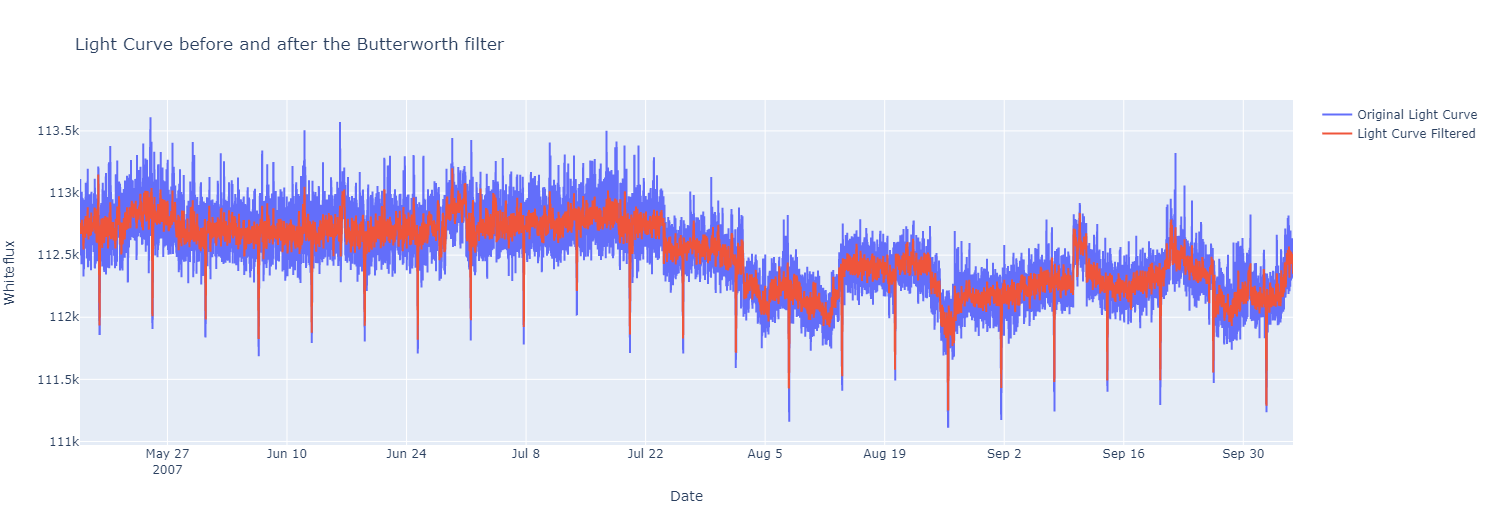

# Choosing the best filtering parameters

---

Since all the Mathematical and Computacional requirements have been prosecuted, we are going to summary all this on a single algorithm. On `filters` module, we have an object `FrequencyDomainFiltering` and it has the method `filter` that make all the signal preprocessing procedures, the filtering and the posprocessing. 

In [23]:
from tools import *

In [24]:
import matplotlib.pyplot as plt

## Keep filter order at 2

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.05, order=2)
y_filtered = Filter.filtered
viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.05')

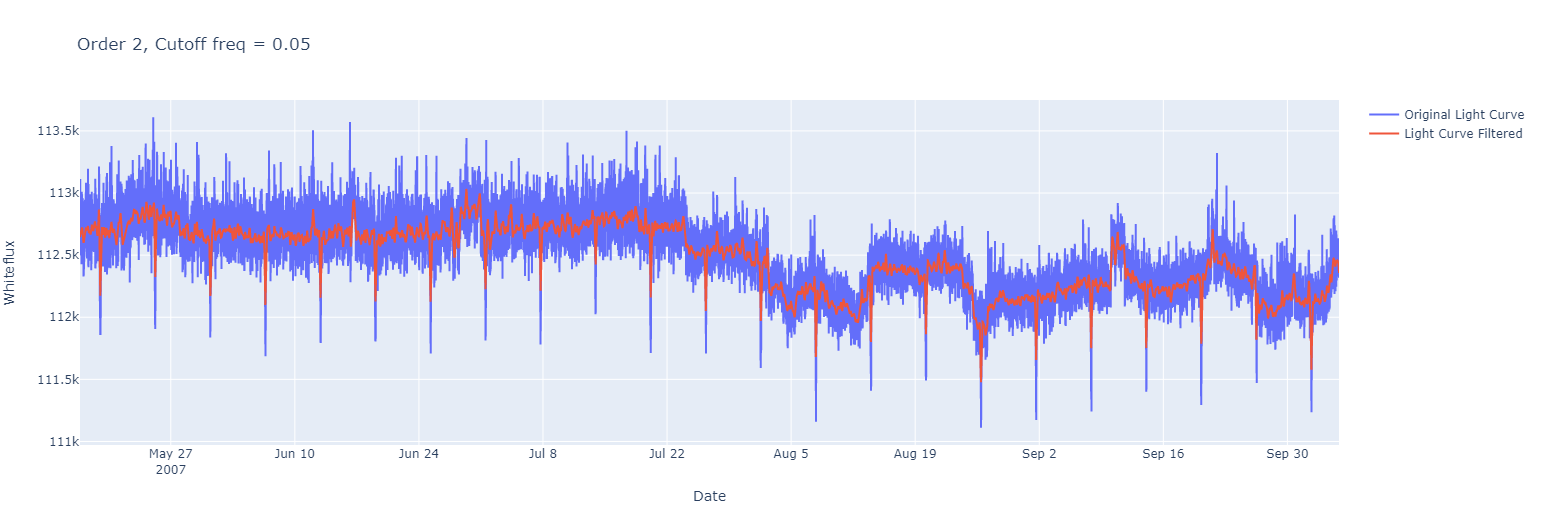

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.1, order=2)
y_filtered = Filter.filtered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.1')

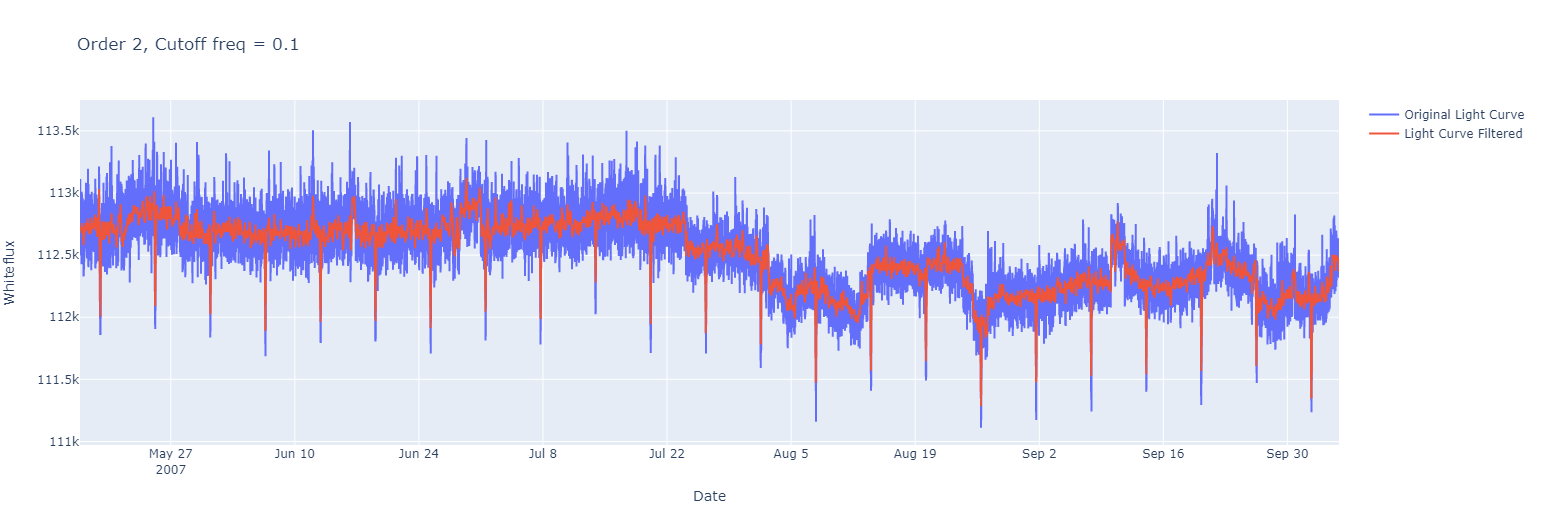

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=2)
y_filtered = Filter.filtered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.2')

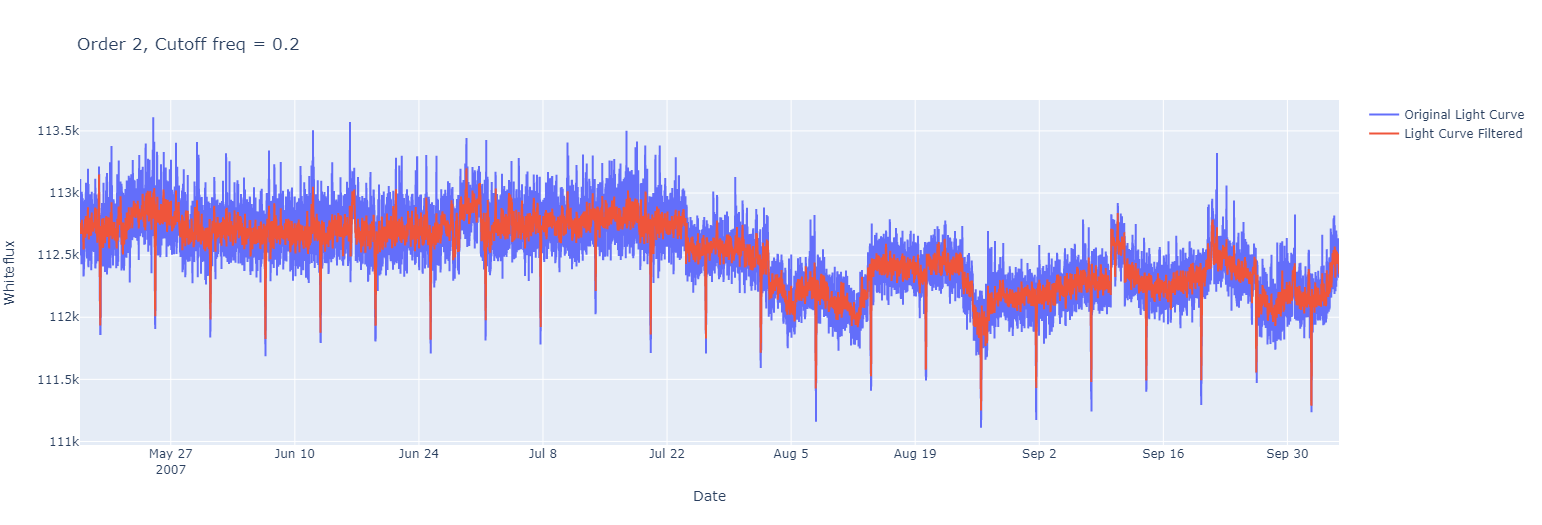

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.3, order=2)
y_filtered = Filter.filtered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.3')

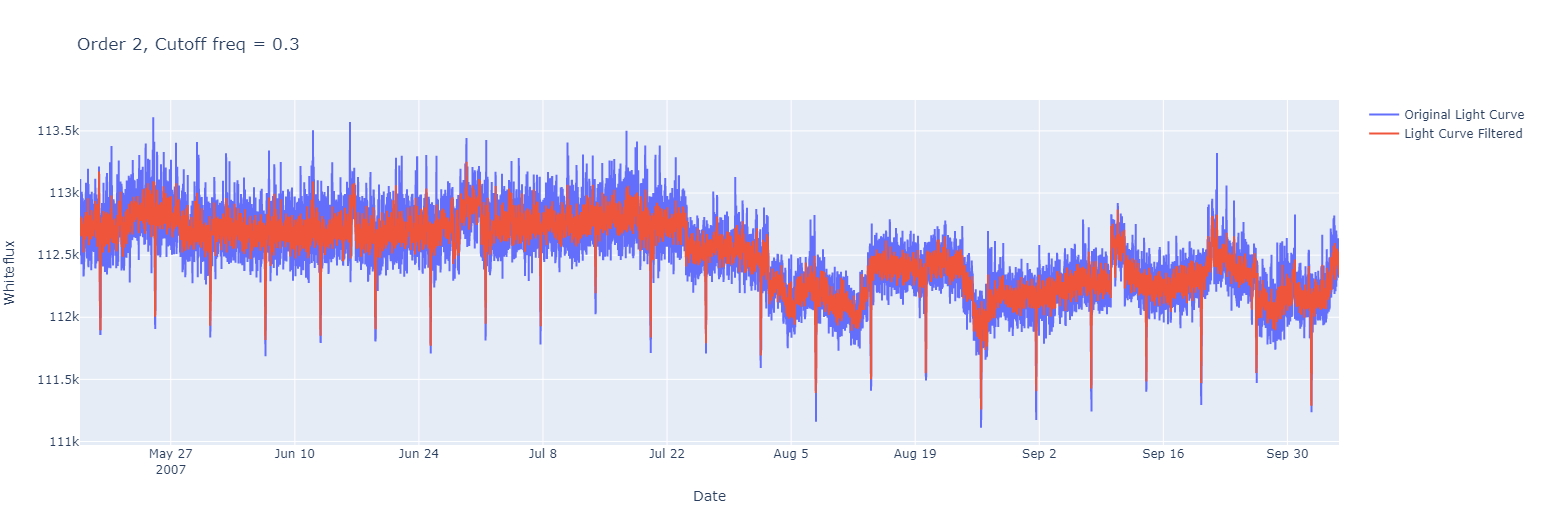

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.4, order=2)
y_filtered = Filter.filtered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.4')

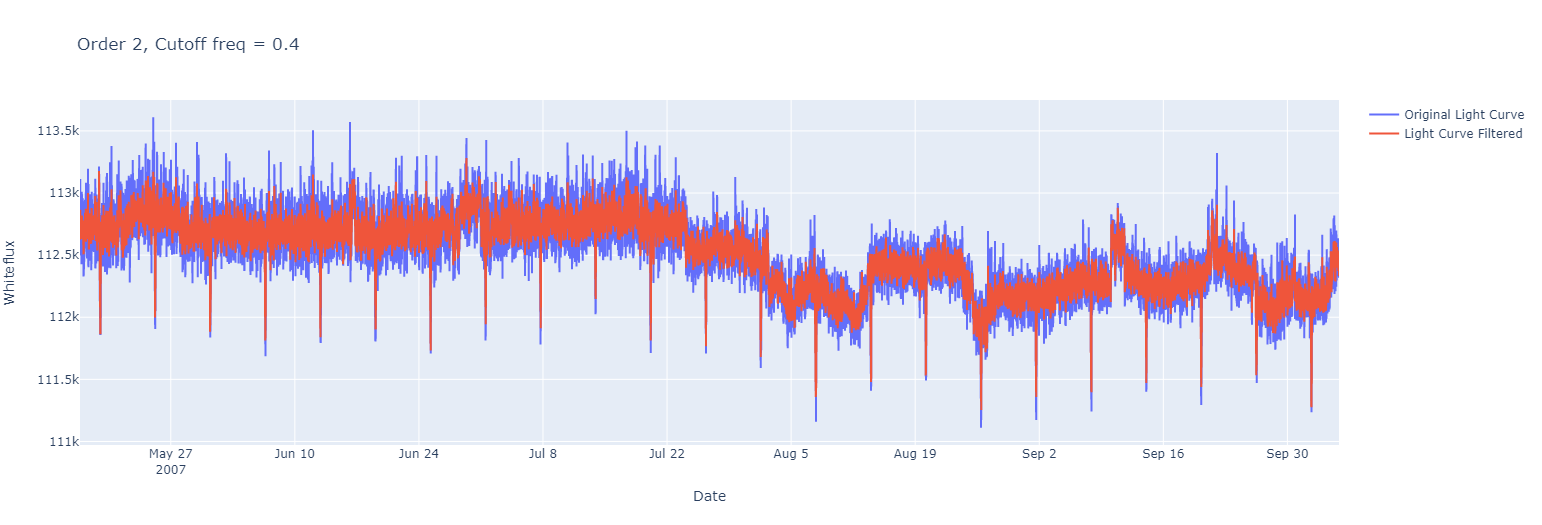

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.5, order=2)
y_filtered = Filter.filtered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.5')

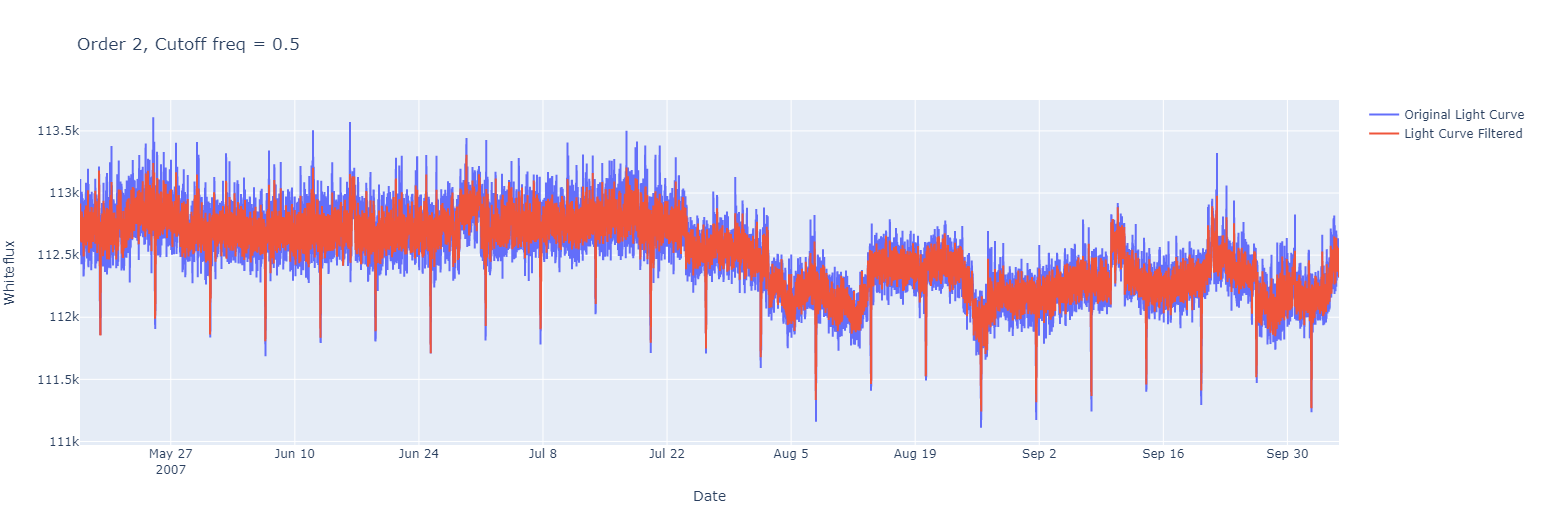

## Keep cutoff frequency at 0.2

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=2)
y_filtered = Filter.filtered
viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.2')
plt.plot(Filter.filter_response)
plt.title('Filter response at butterworth order 2')

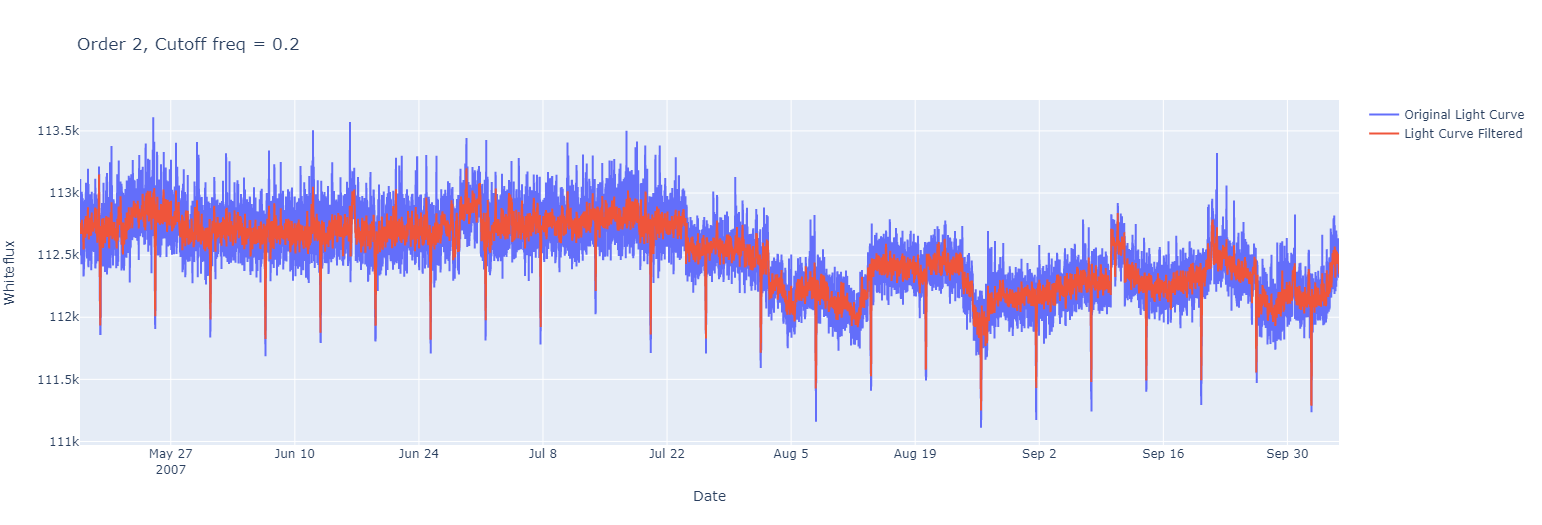

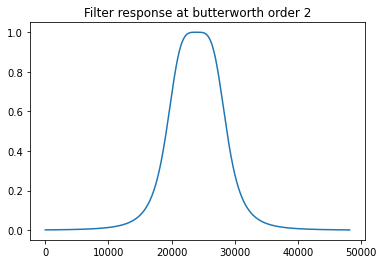

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=3)
y_filtered = Filter.filtered
viz.view_filter_results(x, y, x, y_filtered, title='Order 3, Cutoff freq = 0.2')
plt.plot(Filter.filter_response)
plt.title('Filter response at butterworth order 3')

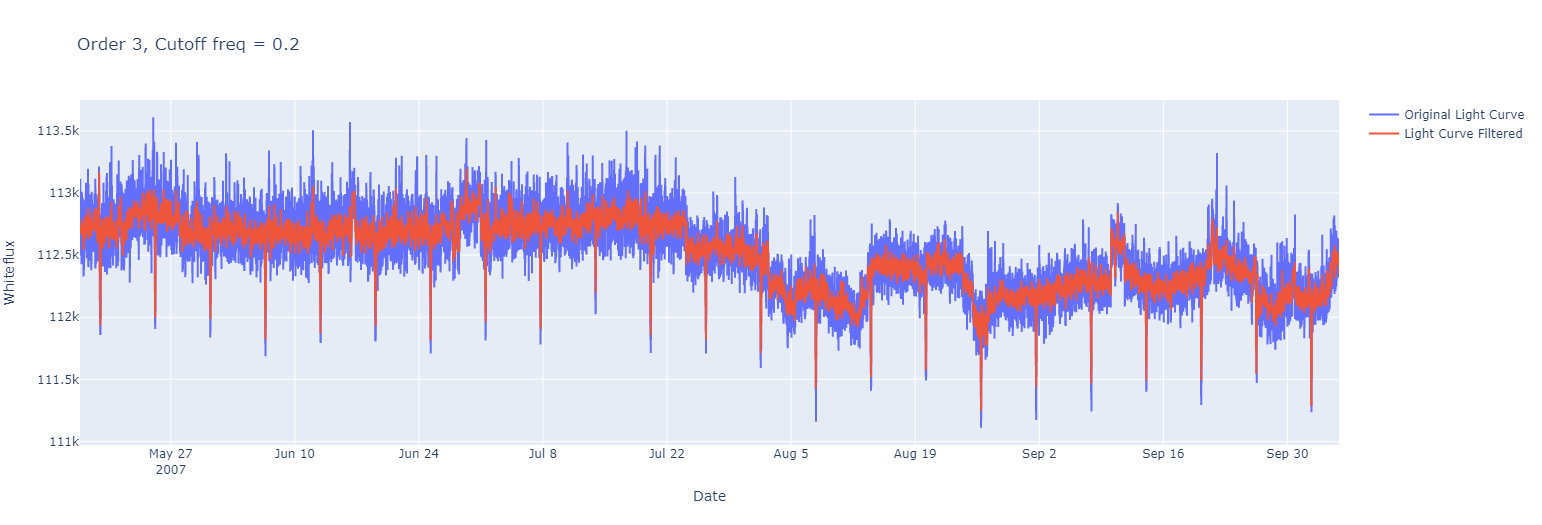

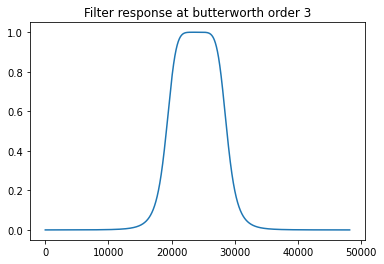

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=4)
y_filtered = Filter.filtered
viz.view_filter_results(x, y, x, y_filtered, title='Order 4, Cutoff freq = 0.2')
plt.plot(Filter.filter_response)
plt.title('Filter response at butterworth order 4')

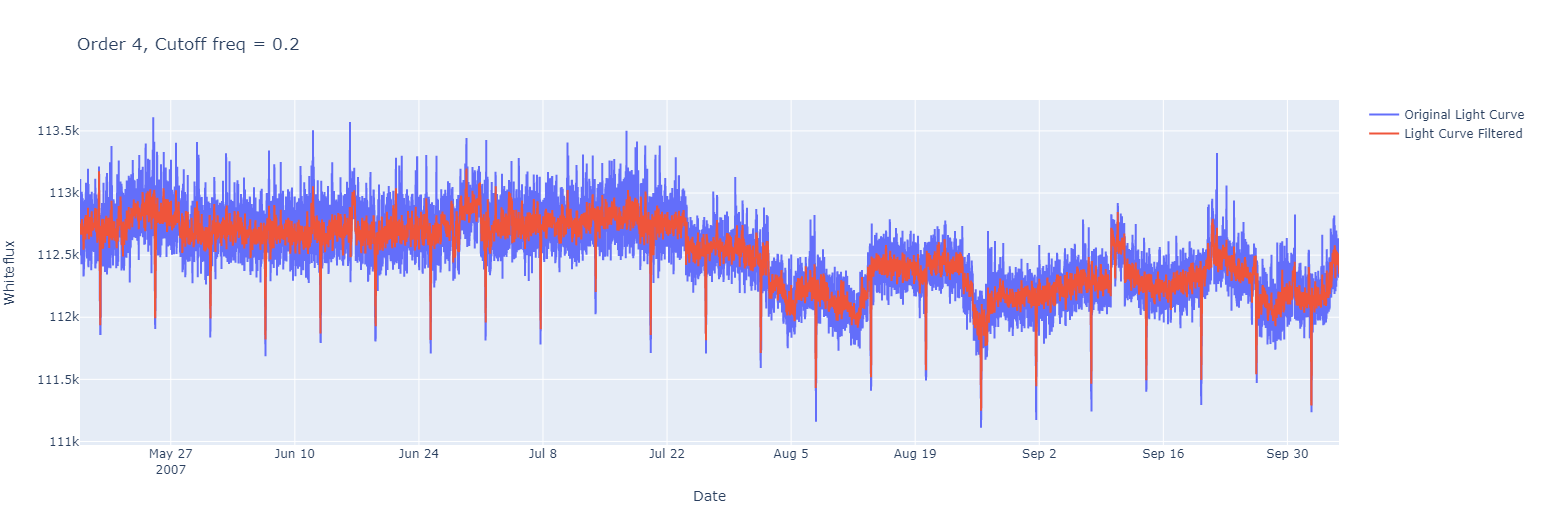

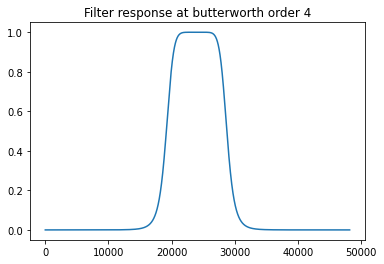

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=5)
y_filtered = Filter.filtered
viz.view_filter_results(x, y, x, y_filtered, title='Order 5, Cutoff freq = 0.2')
plt.plot(Filter.filter_response)
plt.title('Filter response at butterworth order 5')

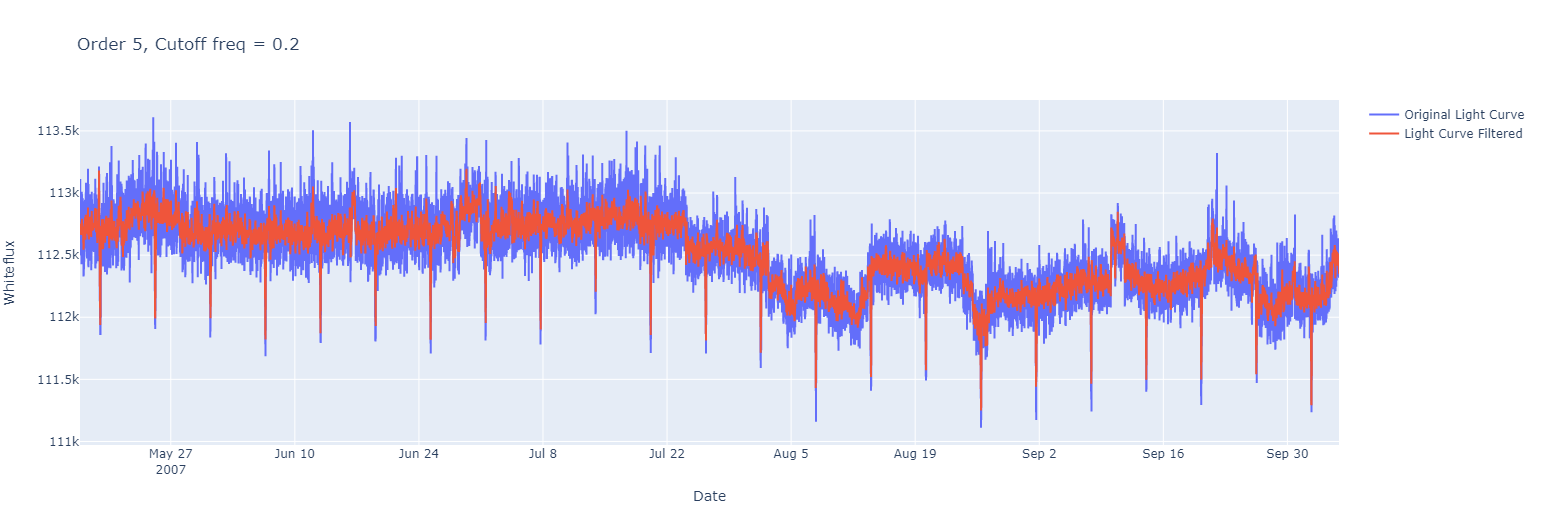

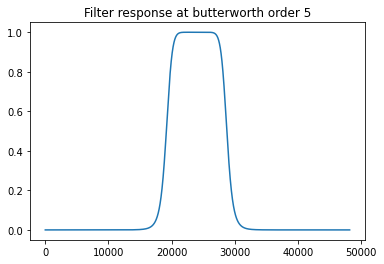